# Project: Movie Classification

I will build a classification model that guesses whether a movie is a comedy or a thriller by using only the number of times chosen words appear in the movies's screenplay. By the end of the project, I should be able to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

In [1]:
import numpy as np
import math
import datascience
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter("ignore")

import d8error

# Part 1: The Dataset

In this project, I am exploring movie screenplays. I'll be trying to predict each movie's genre from the text of its screenplay. In particular, I have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, my dataset tells me the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. **It may take up to a minute to load.**

In [2]:
movies = Table.read_table('movies.csv')
movies.where("Title", "runaway bride").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
runaway bride,1999,5.2,comedy,4895,0,0,0.0234092,0


The above cell prints a few columns of the row for the comedy movie *Runaway Bride*.  The movie contains 4895 words. The word "it" appears 115 times, as it makes up  $\frac{115}{4895} \approx 0.0234092$ of the words in the movie. The word "england" doesn't appear at all.

Additional context: This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. This is a model that is often used in [NLP](https://en.wikipedia.org/wiki/Natural_language_processing). A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. 

In this project, I will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [3]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('toy story')

Row(Title='toy story', Year='1995', Rating=8.2, Genre='comedy', # Words=3016, she=0.0017427675148135, decid=0.0003485535029627, talk=0.0017427675148135, wit=0.0, razor=0.0, slam=0.0, credit=0.0, rai=0.0, hugh=0.0, breez=0.0, conscienc=0.0, audienc=0.0, cathi=0.0, log=0.0, met=0.0, chosen=0.0, grip=0.0, booz=0.0, bianca=0.0, doubl=0.0003485535029627, agent=0.0, exit=0.0, carpent=0.0, underground=0.0, clemenza=0.0, gain=0.0, neg=0.0006971070059254, majesti=0.0, studio=0.0, chri=0.0, spin=0.0, greater=0.0, eaten=0.0, vibrat=0.0, stupid=0.0010456605088881, cigarett=0.0, jesu=0.0, mani=0.0, violin=0.0, financi=0.0003485535029627, bai=0.0, cop=0.0, neighbor=0.0, cd=0.0, england=0.0, made=0.0003485535029627, conni=0.0, instinct=0.0, took=0.0, jacquelin=0.0, mace=0.0, disappear=0.0, waltz=0.0, behind=0.0003485535029627, bourbon=0.0, favorit=0.0006971070059254, benni=0.0, manhattan=0.0, nixon=0.0, lunch=0.0, principl=0.0, tradit=0.0, counterfeit=0.0, sophi=0.0, third=0.0, exist=0.0, wouldv=0.00

For example, the fastest way to find the frequency of "fun" in the movie *Toy Story* is to access the `'fun'` item from its row. Check the original table to see if this worked for you!

In [4]:
row_for_title('toy story').item('fun')

0.0003485535029627

Quick note that by summing all proportions in each row, excluding the first five columns, I should always get a value close to 1.

In [5]:
sum(row_for_title('toy story')[5:])

0.9999999999999946

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), I created this new dataset containing the frequency of 5000 common words in each movie.

In [6]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 333


## 1.1. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words I want to use, so I have provided another table called `vocab_table` that will let you see examples of unstemmed versions of each stemmed word. Run the code below to load it.

In [7]:
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


To learn more about my dataset, I did some exploration.

Using `vocab_table`, I found the stemmed version of the word "elements" and assign it the value to `stemmed_message`.

In [8]:
stemmed_message = vocab_table.where("Word", are.equal_to("elements")).column(0).item(0)
stemmed_message

'element'

I assigned `most_stem` to the stem in the dataset has the most words that are shortened to it. 

In [9]:
most_stem = vocab_table.group('Stem').sort("count", descending=True).column(0).item(0)
most_stem

'gener'

I assigned `longest_uncut` to the longest word in the dataset whose stem wasn't shortened. Noting that to break ties alphabetically from Z to A, I pick the first one(so if my options are "cat" or "bat", you should pick "cat").

In [10]:
with_stem_length = vocab_table.with_columns("Stem Length", [len(word) for word in vocab_table.column("Stem")])
tbl_with_lens = with_stem_length.with_columns("Word Length", [len(word) for word in vocab_table.column("Word")])
tbl_with_diff = tbl_with_lens.with_columns("length difference", tbl_with_lens.column("Stem Length") - tbl_with_lens.column("Word Length"))
same = tbl_with_diff.where("length difference", are.equal_to(0))

longest_uncut = same.sort("Stem Length", descending = True).column(1).item(0)
longest_uncut

'extraordinary'

I assign `count_single_stems` to the count of stems that map to one word only. For example, if the stem "book" only maps to the word "books" and if the stem "a" only maps to the word "a," both should be counted as stems that map only to a single word.

In [11]:
count_single_stems = len(vocab_table.group("Stem").where("count", are.equal_to(1)).column("Stem"))
count_single_stems

1408

## 1.2. Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, I'll use the associated proportions to investigate the relationship between different words.

The first association I'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

As usual, I'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of space proportions vs outer proportions and to create the `outer_space` table. Each point on the scatter plot represents one movie.

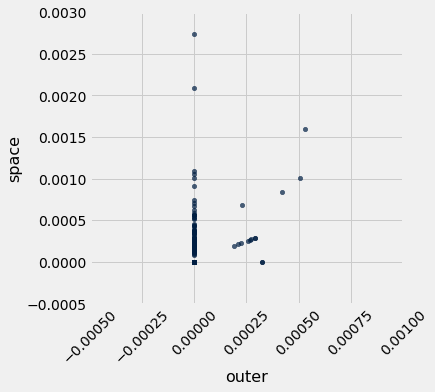

In [12]:
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.0005, 0.001, -0.0005, 0.003]);
plots.xticks(rotation=45);

Looking at that chart it is difficult to see if there is an association. I calculated the correlation coefficient for the potential linear association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assigned it to `outer_space_r`. 

In [13]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

outer = movies.column("outer")
space = movies.column("space")

outer_su = standard_units(outer)
space_su = standard_units(space)

outer_space_r = np.mean(outer_su * space_su)
outer_space_r

0.3194260787689591

I chose two *different* words in the dataset with a magnitude (absolute value) of correlation higher than 0.2 and plot a scatter plot with a line of best fit for them. I plotted the scatter plot and line of best fit and calculated the correct values to `r`, `slope` and `intercept`. 

Refer to [Section 15.2](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#units-of-measurement-of-the-slope) of this textbook for the formulas. 

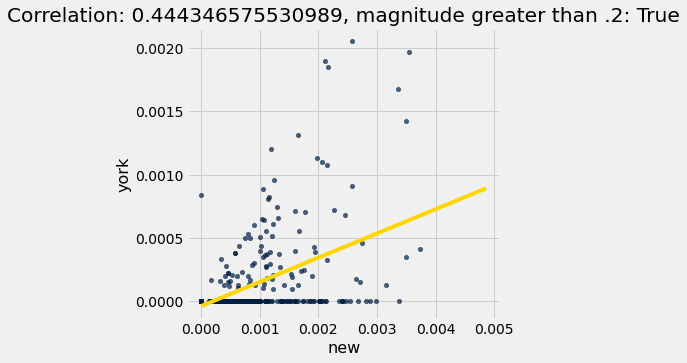

In [14]:
word_x = "new"
word_y = "york"

arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = standard_units(arr_x)
y_su = standard_units(arr_y)

r = np.mean(x_su * y_su)

slope = (r * np.std(arr_y)) / (np.std(arr_x))
intercept = np.mean(arr_y) - (slope * np.mean(arr_x))

movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

## 1.3. Splitting the dataset
Now, I am going to use the `movies` dataset for two purposes.

1. First, I want to *train* movie genre classifiers.
2. Second, I want to *test* the performance of our classifiers. 

Hence, I need two different datasets: *training* and *test*. 

The purpose of a classifier is to classify unseen data that is similar to the training data. The test dataset will help me determine the accuracy of our predictions by comparing the actual genres of the movies with the genres that my classifier predicts. Therefore, I must ensure that there are no movies that appear in both sets. I do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  I just take the first 85% of the dataset for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [15]:
# Here I have defined the proportion of my data
# that I want to designate for training as 17/20ths
# of the total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  283 ; Test:  50


I drew a horizontal bar chart with two bars that show the proportion of comedy movies in each dataset. The two bars should be labeled "Training" and "Test". I completed the function `comedy_proportion` first; it should help me create the bar chart. 

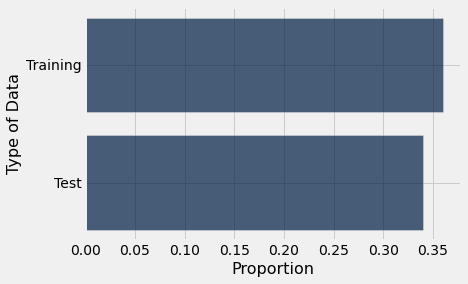

In [16]:
def comedy_proportion(table):
    # Return the proportion of movies in a table that have the comedy genre.
    return len(table.where("Genre", are.equal_to("comedy")).column("Title")) / len(table.column("Title"))

comedy_props =Table(["Type of Data", "Proportion"]).with_rows([["Training", comedy_proportion(train_movies)], ["Test", comedy_proportion(test_movies)]]) 
comedy_props.sort('Proportion', descending=True).barh('Type of Data')


# Part 2: K-Nearest Neighbors - A Guided Example

[K-Nearest Neighbors (k-NN)](https://inferentialthinking.com/chapters/17/1/Nearest_Neighbors.html) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides which category that example belongs to based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, I classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so I can plot each movie.  The features I will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that I don't yet know its genre.

First, I need to make our notion of similarity more precise.  I will say that the *distance* between two movies is the straight-line distance between them when I plot their features on a scatter diagram. 

**This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.**

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Godfather* (in the training set), has 0 "water" and 0.00015122 "feel". 

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to *Clerks.* than to the *The Godfather* based on these features, which makes sense as both movies are comedy movies, while *The Godfather* is a thriller.

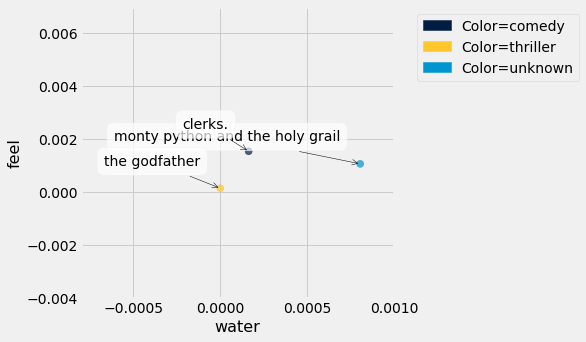

In [17]:
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=50)
    
training = ["clerks.", "the godfather"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

I computed the Euclidean distance (defined in the section above) between the two movies, *Monty Python and the Holy Grail* and *The Godfather*, using the `water` and `feel` features only and assigned it the name `one_distance`. 

In [18]:
python = row_for_title("monty python and the holy grail") 
godfather = row_for_title("the godfather") 

one_distance = (((python.item("water") - godfather.item("water")) ** 2) + ((python.item("feel") - godfather.item("feel")) ** 2)) ** 0.5
one_distance

0.0012225209151294461

Below, I've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

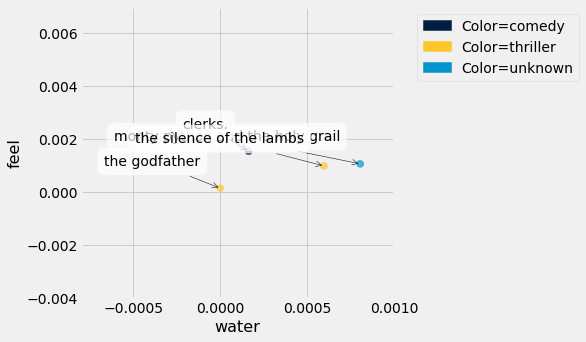

In [19]:
training = ["clerks.", "the godfather", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

I completed the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*. 

In [20]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0) 
    row1 = row_for_title(title1) 
    return (((row0.item(x_feature) - row1.item(x_feature)) ** 2) + ((row0.item(y_feature) - row1.item(y_feature)) ** 2)) ** 0.5

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.0007983810687227716
the silence of the lambs distance:	 0.00022256314855564847


I also defined the function `distance_from_python` so that it works as described in its documentation. 

In [21]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    return distance_two_features(title, "monty python and the holy grail", "water", "feel")

# Calculate the distance between "Clerks." and "Monty Python and the Holy Grail"
distance_from_python('clerks.')

0.0007983810687227716

Using the features `"water"` and `"feel"`,  I made a **table** named `close_movies` containing the 5 movies closest in names and genres to *Monty Python and the Holy Grail*. This table contains the columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*. I also **sorted in ascending order by `distance from python`**.

In [22]:
temp_movies = Table(["Title", "Genre", "water", "feel", "distance from python"])

for title in train_movies[0]:
    movie = row_for_title(title)
    distance = distance_from_python(title)
    genre = movie.item("Genre")
    water = movie.item("water")
    feel = movie.item("feel")
    temp_movies = temp_movies.with_rows([[title, genre, water, feel, distance]])

close_movies = temp_movies.sort("distance from python").take(np.arange(0, 5))
close_movies

Title,Genre,water,feel,distance from python
alien,thriller,0.00070922,0.00124113,0.000193831
tomorrow never dies,thriller,0.000888889,0.000888889,0.00020189
the silence of the lambs,thriller,0.000595948,0.000993246,0.000222563
innerspace,comedy,0.000522193,0.00104439,0.00028324
some like it hot,comedy,0.000528541,0.000951374,0.00030082


Next, I'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies. 

To do so, I defined the function `most_common` so that it works as described in its documentation below. 

In [23]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in the `label` column of the table.
    In case of a tie, it returns any one of the most common values.    
    """
    return table.group(label).sort("count", descending=True)[0][0]

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

Yay! -- I've classified my first movie! However, I can see that the classifier doesn't work too well since it categorized *Monty Python and the Holy Grail* as a thriller movie (unless you count the thrilling holy hand grenade scene). Let's see if I can do better!

# Part 3: Features

Now, I am going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

I wrote a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length.

Next, I used the function I just defined to compute the distance **between the first and second movie** in the **training set** *using all of the features*.  (Noting that the first five columns of the tables are not features.)

In [24]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return (sum((features_array1 - features_array2) ** 2)) ** 0.5

distance_first_to_second = distance(np.array(train_movies.drop(np.arange(6)).row(0)), np.array(train_movies.drop(np.arange(6)).row(1))) 
distance_first_to_second

0.03320761753859238

## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is the lack of *computational efficiency* -- computing Euclidean distances just takes a long time when I have lots of features.  You might have noticed that while running the last function.

So I am going to select just 20.  I'd like to choose features that are very *discriminative*. That is, features which lead me to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

In this question, I will get started on selecting more effective features for distinguishing comedy from thriller movies. The plot below (generated for you) shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis. 


*Note: The line graphed is the line of best fit, NOT the line y=x.*

![alt text](word_plot.png "Title")

I gained these insights from interpreting the plot above. 
1. The word is common in both comedy and thriller movies are in the top right.
2. The word is uncommon in comedy movies and common in thriller movies are in the top left.
3. The word is common in comedy movies and uncommon in thriller movies are in the bottom right.
4. The word is uncommon in both comedy and thriller movies are in the bottom left.

Using the plot above, I made an array of at least 10 common words that I think might let me **distinguish** between comedy and thriller movies. I made sure to choose words that are **frequent enough** that every movie contains at least one of them. 

In [25]:
# Set my_features to an array of at least 10 features (strings that are column labels)
my_features = ["kill", "murder", "dead", "oh", "cop", "love", "well", "waiter", "uh", "great"]

# Select the 10 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)

This test makes sure that I have chosen words such that at least one appears in each movie. Next, I classify the first movie from my test set using these features.  I can examine the movie by running the cells below.

In [26]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
ghostbusters ii,comedy


Features:


kill,murder,dead,oh,cop,love,well,waiter,uh,great
0.000329707,0.000164853,0.000164853,0.00313221,0,0.000824266,0.00362677,0,0.000164853,0.000659413


As before, I want to look for the movies in the training set that are most like the test movie.  I will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.  I created a function `fast_distances` to make it computationally faster rather than using a `for` loop. Read the documentation if you want to make sure you understand what it does.  

In [27]:
def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_table.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    assert type(test_row) != datascience.tables.Table, "Make sure you are passing in a row object to fast_distances."
    assert len(test_row) == len(train_table.row(0)), "Make sure the length of test row is the same as the length of a row in train_table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

I used the `fast_distances` function provided above to compute the distance from the first movie in my test set to all the movies in my training set, **using your set of features**.  I made a new table called `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

I ensured that `genre_and_distances` is **sorted in ascending order by distance to the first test movie**.

In [28]:
genre_and_distances = Table().with_columns("Genre", train_movies.column("Genre"), "Distance", fast_distances(test_my_features.row(0), train_my_features))
genre_and_distances = genre_and_distances.sort("Distance")
genre_and_distances

Genre,Distance
thriller,0.00110858
comedy,0.00124483
comedy,0.00154933
comedy,0.00164243
comedy,0.00169255
thriller,0.00172654
comedy,0.00172896
comedy,0.00178097
comedy,0.00182959
comedy,0.001865


Now I computed the 7-nearest neighbors classification of the first movie in the test set.  That is, I decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances I've calculated.  Then I checked whether my classifier chose the right genre.  (Depending on the features I chose, my classifier might not get this movie right, and that's okay.)

In [29]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common("Genre", genre_and_distances.take(np.arange(7)))

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set, False otherwise.
my_assigned_genre_was_correct = my_assigned_genre == test_movies.column("Genre").item(0)

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, comedy, was correct.


## 3.2. A classifier function

Now I can write a single function that encapsulates the whole process of classification.

I wrote a function called `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order. 
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`). 

In [30]:
def classify(test_row, train_features, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_features)
    genre_and_distances = Table().with_columns("Genre", train_labels, "Distance", distances).sort("Distance")
    return most_common("Genre", genre_and_distances.take(np.arange(k)))

I assigned `godzilla_genre` to the genre predicted by my classifier for the movie "godzilla" in the test set, using **15 neighbors** and using your 10 features. 

In [31]:
# The staff solution first defined a row called godzilla_features.
godzilla_features = ["nuclear", "monster", "earth", "shot", "attack", "war", "kill", "action", "weapon", "destroi"]
train_features = train_movies.select(godzilla_features)
test_features = test_movies.where("Title", are.equal_to("godzilla")).select(godzilla_features).row(0)
godzilla_genre = classify(test_features, train_features, train_movies.column("Genre"), 15)
godzilla_genre

'thriller'

Finally, when I evaluate my classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

I created a classification function that takes as its argument a row containing your 10 features and classifies that row using the 15-nearest neighbors algorithm with `train_my_features` as its training set. 

In [32]:
def classify_feature_row(row):
    return classify(row, train_my_features, train_movies.column("Genre"), 15)

classify_feature_row(test_my_features.row(0))

'comedy'

## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1**

I used `classify_feature_row` and `apply` to classify every movie in the test set.  I assigned these guesses as an array to `test_guesses`.  Then, I computed the proportion of correct classifications.

In [33]:
test_guesses = test_my_features.apply(classify_feature_row)
proportion_correct = sum(test_guesses == test_movies.column("Genre")) / len(test_guesses)
proportion_correct

0.76

An important part of evaluating your classifiers is figuring out where they make mistakes. I assigned the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. 

- The `'Genre'` column should contain the original genres, not the ones you predicted. 
- The `'Was correct'` column should contain `True` or `False` depending on whether or not the movie was classified correctly.

In [38]:
test_movie_correctness = Table().with_columns("Title", test_movies.column("Title"), "Genre", test_movies.column("Genre"), "Was correct", test_guesses == test_movies.column("Genre"))
#I've only shown 30 movies in the table
test_movie_correctness.sort('Was correct', descending = True).show(30)

Title,Genre,Was correct
ghostbusters ii,comedy,True
intolerable cruelty,comedy,True
psycho,thriller,True
book of shadows: blair witch 2,thriller,True
the getaway,thriller,True
broadcast news,comedy,True
mission: impossible,thriller,True
meet john doe,comedy,True
arctic blue,thriller,True
the world is not enough,thriller,True


I can see that there are more thriller movies in the test set. Rather than looking at what I classified wrong since I did an equal number of misclassification on both genres, I did pretty well on classifying which one is thriller than a comedy one.

At this point, I've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for k-NN classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

# Part 4: Explorations
Now that I know how to evaluate a classifier, it's time to build another one.

My friends are big fans of comedy and thriller movies. They have created their own dataset of movies that they want to watch, but they need my help in determining the genre of each movie in their dataset (comedy or thriller). I have never seen any of the movies in my friends' dataset, so none of my friends' movies are present in your training or test set from earlier. In other words, this new dataset of movies can function as another test set that I am going to make predictions on based on my original training data. 

Run the following cell to load my friends' movie data.

In [39]:
friend_movies = Table.read_table('friend_movies.csv')
friend_movies.show(5)

My friend's computer is not as powerful as mine, so they tell me that the classifier I can create for them can only have up to 5 words as features. I developed a new classifier with the constraint of **using no more than 5 features. I assigned `new_features` to an array of your features.

My new function should have the same arguments as `classify_feature_row` and return a classification. I named it `another_classifier`. Then, I output my accuracy using code from earlier to compare the new classifier to my old one. 

Some ways I can change my classifier are by using different features or trying different values of `k`. (Of course, you still have to use `train_movies` as your training set!)

**I made sure I don't reassign any previously used variables here**, such as `proportion_correct` from the previous question.

*Note:* There's no one right way to do this! I just make sure that I can explain my reasoning behind the new choices.

In [40]:
new_features = ["oh", "kill", "death", "love"]

train_new = train_movies.select(new_features)
test_new = friend_movies.select(new_features)

def another_classifier(row):
    return classify(row, train_new, train_movies.column("Genre"), 10)

friend_guesses = test_new.apply(another_classifier)
friend_proportion_correct = sum(friend_guesses == friend_movies.column("Genre")) / len(friend_guesses)

test_friend_correctness = Table().with_columns("Title", friend_movies.column("Title"), "Genre", friend_movies.column("Genre"), "Was correct", friend_guesses == friend_movies.column("Genre"))
test_friend_correctness.show()
friend_proportion_correct

Title,Genre,Was correct
black rain,thriller,True
bringing out the dead,thriller,True
basic,thriller,True
detroit rock city,comedy,True
panic room,thriller,True
juno,comedy,True
my girl 2,comedy,True
nick of time,thriller,True
hannibal,thriller,True
airplane ii: the sequel,comedy,True


0.8108108108108109

I noticed that using too many features did not help my classifier at all. It actually made my classify overfit to the training data set, thus doing really bad when classifying the test dataset. I lessened the features and made sure to include only the ones that actually affect my dataset.

Now that I've finished my k-NN classifier, you might be wondering what else I could do to improve the accuracy on the test set. Classification is one of many machine learning tasks, and there are plenty of other classification algorithms! If you feel so inclined, I encourage you to try any methods you feel might help improve your classifier. 

I've compiled a list of blog posts with some more information about classification and machine learning.

Blog posts: 

* [Classification algorithms/methods](https://medium.com/@sifium/machine-learning-types-of-classification-9497bd4f2e14)
* [Train/test split and cross-validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
* [More information about k-nearest neighbors](https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7)
* [Overfitting](https://elitedatascience.com/overfitting-in-machine-learning)

In you future data science journey, you'll learn more about overfitting, cross-validation, and approaches to different kinds of machine learning problems.

One module that you can consider using is [Scikit-learn](http://scikit-learn.org/stable/tutorial/basic/tutorial.html). There's a lot to think about, so I encourage you to find more information on your own!